<a href="https://colab.research.google.com/github/uervitonsantos/Atividade_Analise_Bayeseana_Com_RSTAN/blob/main/trabalho_de_estatistivca_bayesiana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Atividade de analise inferencial Bayseana com RStan aplicado em um conjunto de dados de confiabilidade de motores

Estimating Generalized Linear Models for Count Data with rstanarm: https://mc-stan.org/rstanarm/articles/count.html

Poisson regression in Stan: https://rpubs.com/kaz_yos/stan-pois1

Negative Binomial Distribution: https://rpubs.com/mpfoley73/458738

Estatística Bayesiana com R e Stan. prof. José Eduardo Storopoli: https://www.youtube.com/watch?v=m_kJwaL2KHQ&list=PLpTXaEnTpmwNwBwwwLTDmCLekoUPtc0cP&index=10

Aula Inferência Bayesiana com prof. Gustavo Ferreira: https://www.youtube.com/watch?v=YKZ1euMRsbs&list=PL5nbzsxqG2FPrVmqbLafXqOrE3djThquN

https://study.sagepub.com/sites/default/files/chapter16.pdf

Beginners Exercise: Bayesian computation with Stan and Farmer Jöns: https://www.sumsar.net/files/posts/2017-01-15-bayesian-computation-with-stan-and-farmer-jons/stan_exercise.html

Stan: https://mc-stan.org/

Plotting Bayesian models: http://mc-stan.org/bayesplot/

How to Use the rstanarm Package: https://mc-stan.org/rstanarm/articles/rstanarm.html

Count Outcome Models with Stan: https://rpubs.com/kaz_yos/stan_count2

Simulate and fit negative binomial GLMs in Stan: http://rstudio-pubs-static.s3.amazonaws.com/34099_2e35c3966ef548c2918d5b6c2146bfd1.html

In [ ]:
!pip install rpy2==3.5.4

In [2]:
%load_ext rpy2.ipython

In [ ]:
%%R
# install e chamada dos pacotes necessarios para o analise dos dados
if(!require(rstanarm))
install.packages("rstanarm")
if(!require(ggpubr))
install.packages("ggpubr")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%R
library(ggplot2)
library(dplyr)
library(bayesplot)
library(rstanarm)
library(ggpubr)
theme_set(bayesplot::theme_default())

In [38]:
%%R
df <- read.csv("/content/drive/MyDrive/Colab Notebooks/DateSet/Motor_Bomba.csv", header = TRUE, sep = ";", dec = ",")

In [39]:
%%R
str(df)

'data.frame':	363 obs. of  23 variables:
 $ ano                           : int  2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 ...
 $ dia                           : int  2 3 4 5 6 7 8 9 10 11 ...
 $ falha                         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ severidade_mc                 : int  0 0 0 0 0 0 0 0 0 0 ...
 $ temp_estator_fase_U           : int  38 38 38 38 38 38 38 38 38 38 ...
 $ temp._estator_fase_v          : int  40 40 40 40 40 40 40 40 40 40 ...
 $ temp_estator_fase_wa          : int  37 37 37 37 37 37 37 36 36 36 ...
 $ temp_estator_fase_wb          : int  39 39 39 39 39 39 39 39 39 39 ...
 $ vibracoo_bomba_la             : int  0 0 0 0 0 0 0 0 0 0 ...
 $ vazao_bomba                   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ corrente                      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ pressao_desc.                 : int  0 0 0 0 0 0 0 0 0 0 ...
 $ pressao_suc                   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ posicao_fcv                   : int  0 0 0 0 0 0 0 0

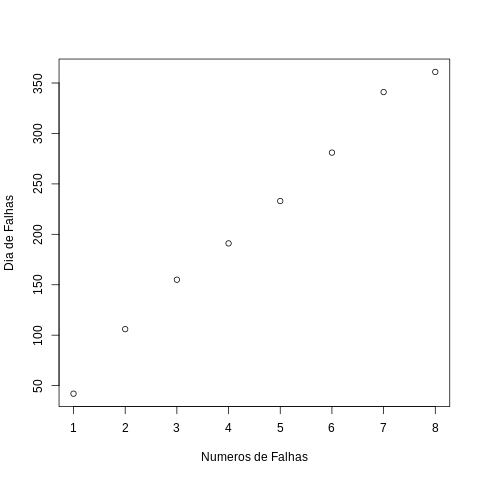

In [40]:
%%R
plot(df$dia[df$falha > "0"], ylab="Dia de Falhas", xlab="Numeros de Falhas")
lines(density(df$falha),
 lwd = 2,
 col = "red")

In [41]:
%%R
sd(df$falha) %>% log

[1] -1.917244


In [42]:
%%R
sd(df$dia) %>% log

[1] 4.653325


In [43]:
%%R
sd(df$severidade_mc) %>% log

[1] 2.205596


In [124]:
%%R
# Estimate Bayesian version with stan_glm
stan_glm1 <- stan_glm(falha ~ dia + severidade_mc 
                                                  + temp_estator_fase_U
                                                  + temp_estator_fase_wa
                                                  + temp_estator_fase_wb
                                                  + vibracoo_bomba_la
                                                  + corrente
                                                  + pressao_desc.
                                                  + pressao_suc
                                                  + temp_externo_mancal_escora_lna
                                                  + temp_interno_mancal_escora_lna
                                                  + temp_mancal_la_bomba
                                                  + temp_mancal_la_motor
                                                  + temp_mancal_lna_bomba
                                                  + temp_mancal_lna_motor
                                                  + temp_oleo_ulf ,
                      data = df,  
                      family = poisson, 
                      prior = normal(0,2.5),
                      prior_intercept = normal(0,5),
                      chains = 4, 
                      cores = 1, 
                      seed = 123, 
                      refresh=0
                    )
summary(stan_glm1)


Model Info:
 function:     stan_glm
 family:       poisson [log]
 formula:      falha ~ dia + severidade_mc + temp_estator_fase_U + temp_estator_fase_wa + 
	   temp_estator_fase_wb + vibracoo_bomba_la + corrente + pressao_desc. + 
	   pressao_suc + temp_externo_mancal_escora_lna + temp_interno_mancal_escora_lna + 
	   temp_mancal_la_bomba + temp_mancal_la_motor + temp_mancal_lna_bomba + 
	   temp_mancal_lna_motor + temp_oleo_ulf
 algorithm:    sampling
 sample:       4000 (posterior sample size)
 priors:       see help('prior_summary')
 observations: 363
 predictors:   17

Estimates:
                                 mean   sd     10%    50%    90% 
(Intercept)                     -98.2  275.9 -560.5    8.0  157.9
dia                              -0.2    1.6   -2.3   -0.2    1.9
severidade_mc                     1.2    1.4   -1.2    1.7    2.5
temp_estator_fase_U               2.1    2.0   -0.4    2.1    4.6
temp_estator_fase_wa              0.3    2.8   -3.6    0.3    4.1
temp_estator

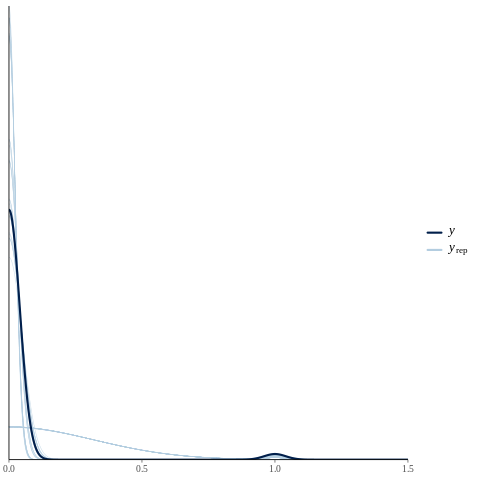

In [125]:
%%R
pp_check(stan_glm1, ndraws = 50) + xlim(0, 1.5)

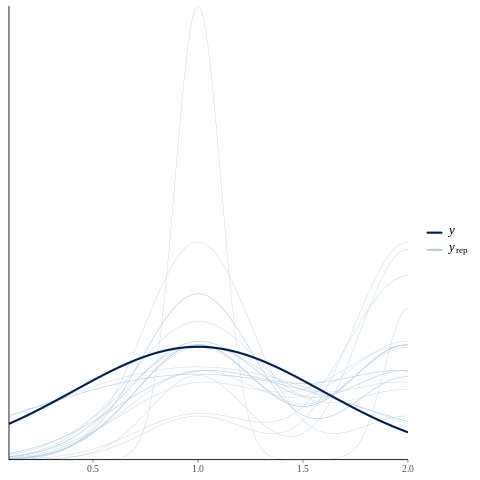

In [126]:
%%R
pp_check(stan_glm1, ndraws = 50) + xlim(0.1, 2)

In [127]:
%%R
stan_glm2 <- stan_glm(falha ~ dia + severidade_mc 
                                                  + temp_estator_fase_U
                                                  + temp_estator_fase_wa
                                                  + temp_estator_fase_wb
                                                  + vibracoo_bomba_la
                                                  + corrente
                                                  + pressao_desc.
                                                  + pressao_suc
                                                  + temp_externo_mancal_escora_lna
                                                  + temp_interno_mancal_escora_lna
                                                  + temp_mancal_la_bomba
                                                  + temp_mancal_la_motor
                                                  + temp_mancal_lna_bomba
                                                  + temp_mancal_lna_motor
                                                  + temp_oleo_ulf 
                      ,
                      data = df,  
                      family = neg_binomial_2,
                      prior = normal(0,2.5),
                      prior_intercept = normal(0,5),
                      prior_aux = rstanarm::exponential(1),
                      chains = 4, 
                      cores = 1, 
                      seed = 123, 
                      refresh=0
)

summary(stan_glm2)


Model Info:
 function:     stan_glm
 family:       neg_binomial_2 [log]
 formula:      falha ~ dia + severidade_mc + temp_estator_fase_U + temp_estator_fase_wa + 
	   temp_estator_fase_wb + vibracoo_bomba_la + corrente + pressao_desc. + 
	   pressao_suc + temp_externo_mancal_escora_lna + temp_interno_mancal_escora_lna + 
	   temp_mancal_la_bomba + temp_mancal_la_motor + temp_mancal_lna_bomba + 
	   temp_mancal_lna_motor + temp_oleo_ulf
 algorithm:    sampling
 sample:       4000 (posterior sample size)
 priors:       see help('prior_summary')
 observations: 363
 predictors:   17

Estimates:
                                 mean   sd    10%   50%   90%
(Intercept)                    -24.5   29.1 -61.7 -23.8  11.5
dia                              0.0    0.0   0.0   0.0   0.1
severidade_mc                    0.2    0.0   0.1   0.2   0.2
temp_estator_fase_U             -0.8    1.1  -2.1  -0.8   0.6
temp_estator_fase_wa            -0.1    0.2  -0.4  -0.1   0.1
temp_estator_fase_wb         

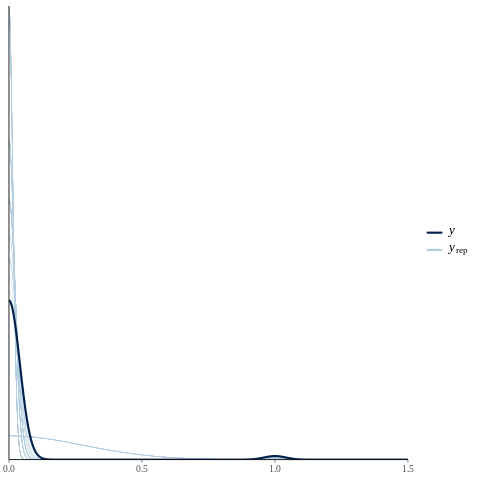

In [132]:
%%R
pp_check(stan_glm2, ndraws = 50) + xlim(0, 1.5)

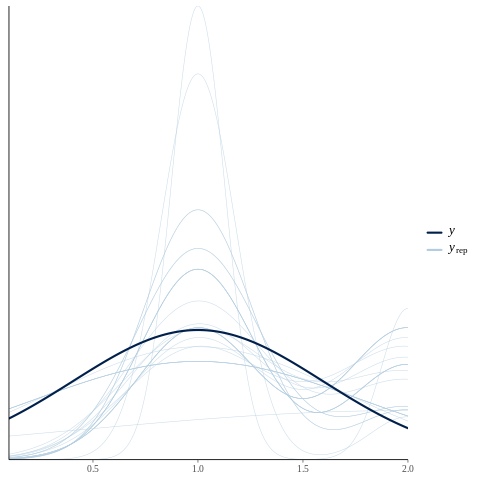

In [133]:
%%R
pp_check(stan_glm1, ndraws = 50) + xlim(0.1, 2)

In [135]:
%%R
test1 <- pp_check(stan_glm1,  ndraws = 50) + xlim(0.1, 2)
test2 <- pp_check(stan_glm2, ndraws = 50) + xlim(0.1, 2)

test3 <- pp_check(stan_glm1, ndraws = 50) + xlim(0, 1.5)
test4 <- pp_check(stan_glm2, ndraws = 50) + xlim(0, 1.5)


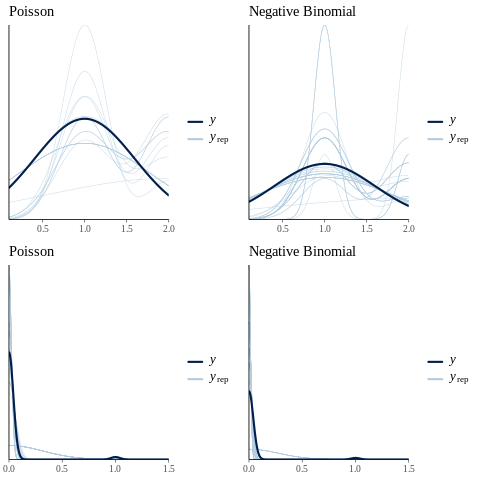

In [136]:
%%R
t1 <- test1 + ggtitle("Poisson")
t2 <- test2 + ggtitle("Negative Binomial")
t3 <- test3 + ggtitle("Poisson")
t4 <- test4 + ggtitle("Negative Binomial")

ggarrange(t1, t2, t3, t4, ncol = 2, nrow = 2)

In [102]:
%%R
library(loo)

In [103]:
%%R
loo_poisson <- loo::loo(stan_glm1)
loo_negbinomial <- loo::loo(stan_glm2)

In [104]:
%%R
loop <- loo::loo_compare(loo_poisson, loo_negbinomial)
loop

          elpd_diff      se_diff       
stan_glm2   0.000000e+00   0.000000e+00
stan_glm1 -1.212171e+157            Inf


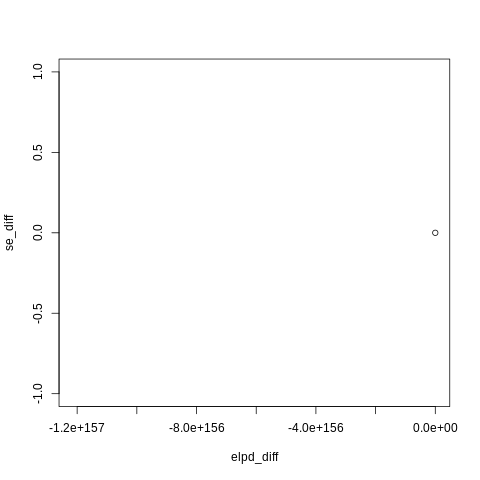

In [105]:
%%R
plot(loop)